In [1]:
print("Kernel funcionando")
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
print("Todo OK")

Kernel funcionando
Todo OK


In [ ]:
#Paso 1: simulación data base de 300 pacientes 

In [3]:
import numpy as np
import pandas as pd

np.random.seed(42)
N = 300

edad = np.random.randint(18, 90, N)
comorbilidades = np.random.randint(0, 11, N)
tipo_cirugia = np.random.choice([1, 2, 3], N)   # 1=Menor, 2=Media, 3=Mayor
estancia_previa = np.random.randint(0, 15, N)

# Regla NO lineal para generar complicaciones
complicacion = (
    (edad > 65).astype(int) +
    (comorbilidades > 6).astype(int) +
    ((tipo_cirugia == 3) & (edad > 50)).astype(int) +
    (estancia_previa > 10).astype(int)
)

# Ruido aleatorio + binarización
complicacion = (complicacion + np.random.binomial(1, 0.15, N) > 1).astype(int)

df = pd.DataFrame({
    'Edad': edad,
    'Comorbilidades_Indice': comorbilidades,
    'Tipo_Cirugia': tipo_cirugia,
    'Estancia_Previa': estancia_previa,
    'Complicacion': complicacion
})

df.head()


,Edad,Comorbilidades_Indice,Tipo_Cirugia,Estancia_Previa,Complicacion
0,69,6,1,8,0
1,32,9,1,1,0
2,89,6,3,14,1
3,78,9,2,10,1
4,38,2,3,7,0


In [ ]:
#Paso2: one-hot encoding y train test

In [4]:
from sklearn.model_selection import train_test_split

# Variables explicativas
X = df[['Edad', 'Comorbilidades_Indice', 'Tipo_Cirugia', 'Estancia_Previa']]
y = df['Complicacion']

# One-Hot Encoding con pandas (simple, robusto y recomendado)
X_encoded = pd.get_dummies(X, columns=['Tipo_Cirugia'], drop_first=True)

# División train/test 70/30
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42
)

X_train.head()


,Edad,Comorbilidades_Indice,Estancia_Previa,Tipo_Cirugia_2,Tipo_Cirugia_3
194,69,8,3,False,False
101,82,9,8,False,True
68,70,8,4,False,False
224,89,10,7,True,False
37,21,4,9,True,False


In [ ]:
#Paso 3: Arbol de decision modelo no lineal explicito 

In [5]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

# Predicciones
y_pred_tree = tree_model.predict_proba(X_test)[:, 1]

# AUC del árbol
auc_tree = roc_auc_score(y_test, y_pred_tree)
auc_tree


0.9117797042325345

In [ ]:
#Paso 4: Visualización del árbol

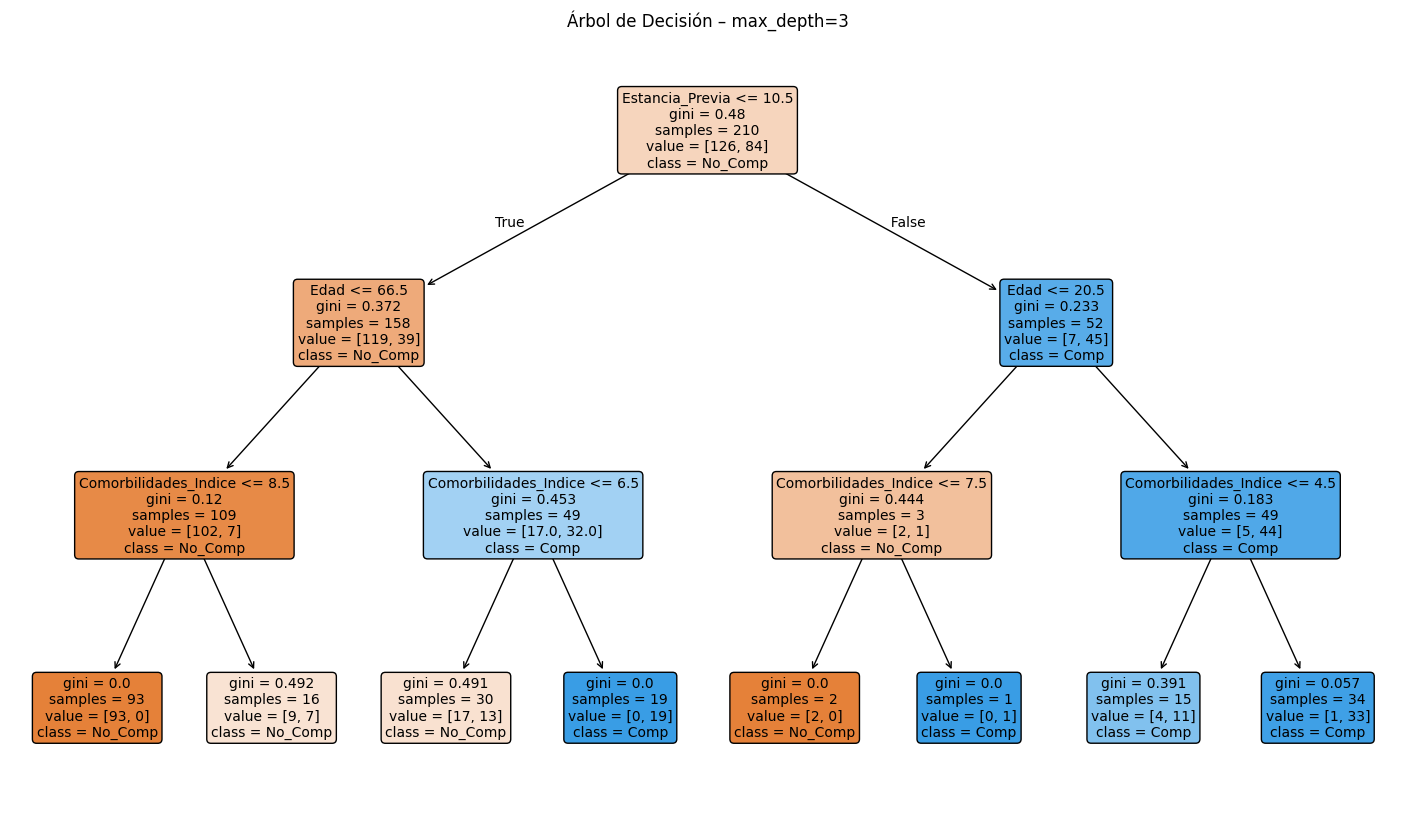

In [10]:
plt.figure(figsize=(18, 10))
plot_tree(
    tree_model,
    filled=True,
    feature_names=X_train.columns,
    class_names=['No_Comp', 'Comp'],
    rounded=True,
    fontsize=10
)
plt.title("Árbol de Decisión – max_depth=3")
plt.show()


In [ ]:
#Paso 5: Modelo lineal baseline regresion logistica

In [7]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict_proba(X_test)[:, 1]

auc_log = roc_auc_score(y_test, y_pred_log)
auc_log


0.9403365629780724

In [ ]:
#Paso 6: Modelo de ensamblaje: Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]

auc_rf = roc_auc_score(y_test, y_pred_rf)
auc_rf


0.9614992350841408

In [ ]:
#Paso 7: importancia de atributos

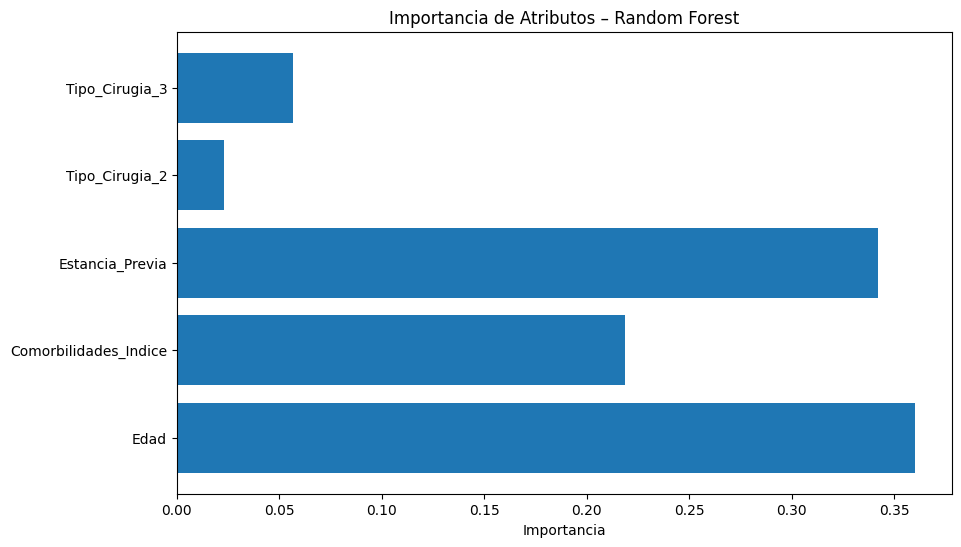

In [9]:
importances = rf.feature_importances_
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.title("Importancia de Atributos – Random Forest")
plt.xlabel("Importancia")
plt.show()
